# Experiment 8

## Parasites
https://www.kaggle.com/brsdincer/cell-images-parasitized-or-not

Dit is een dataset van plaatjes van cellen, waarbij je een distinctie zal proberen te maken tussen geparasiteerde
cellen en niet.

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from misc_utilities import classification_metrics, plot_conf_matrix, plot_fit_curves

## Analyse probleem
#### Wat is het probleem?
Binaire classificatie
#### Dimensies dataset?
12480 plaatjes in beide classes
#### Soorten data/features?
2 features, .png files

## Methoden
#### Welke model ga je gebruiken?
Convolutional Neural Network
#### Welke performance metric is passend?
Accuracy is prima, de balans tussen de classes is praktisch hetzelfde.

## Process

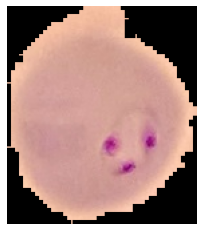

Parasitized


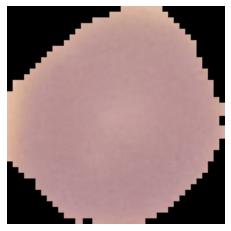

Uninfected
Dimensions of file: (115, 115, 3)


In [33]:
img = mpimg.imread('cell_images/train/parasitized\C33P1thinF_IMG_20150619_114756a_cell_179.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
print("Parasitized")

img = mpimg.imread("cell_images/train/uninfected\C1_thinF_IMG_20150604_104722_cell_9.png")
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
print("Uninfected")
print(f"Dimensions of file: {np.shape(img)}")

In [34]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   validation_split=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zca_whitening=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

a:\software\coding projects\aai\aaivenv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [35]:
train_ds = image_dataset_from_directory('cell_images/train',
                                        validation_split=0.2,
                                        subset="training",
                                        seed=5,
                                        batch_size=32)

val_ds = image_dataset_from_directory('cell_images/train',
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=5,
                                      batch_size=64)

test_ds = image_dataset_from_directory('cell_images/test',
                                       seed=5,
                                       batch_size=64,
                                       shuffle=False)

Found 24958 files belonging to 2 classes.
Using 19967 files for training.
Found 24958 files belonging to 2 classes.
Using 4991 files for validation.
Found 2600 files belonging to 2 classes.


Showing samples from generated data sets, this may take a few seconds.
Image shape is (256, 256, 3)


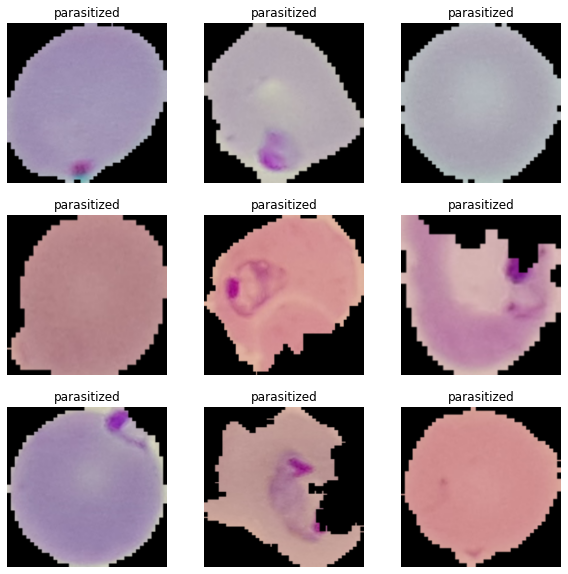

In [36]:
print("Showing samples from generated data sets, this may take a few seconds.")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if i == 0:
            print(f"Image shape is {images[i].numpy().shape}")
        plt.title(train_ds.class_names[labels[0]])
        plt.axis("off")

In [37]:
conv = Sequential()
conv.add(Conv2D(64, 5, input_shape=(256, 256, 3), padding='same'))
conv.add(BatchNormalization())
conv.add(LeakyReLU(0.1))
conv.add(MaxPooling2D())

conv.add(Conv2D(96, 3, padding='same'))
conv.add(BatchNormalization())
conv.add(LeakyReLU(0.1))
conv.add(MaxPooling2D())

conv.add(Flatten())
conv.add(Dense(256, activation=LeakyReLU(0.1)))
conv.add(Dense(1, activation='sigmoid'))

conv.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics='accuracy')

In [38]:
hist = conv.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
624/624 [==============================] - 136s 216ms/step - loss: 21.6752 - accuracy: 0.5940 - val_loss: 3.3291 - val_accuracy: 0.6612

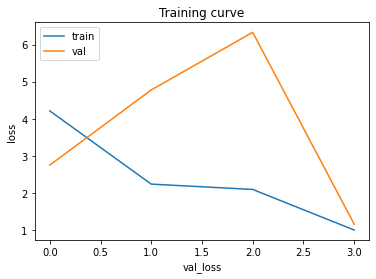

In [39]:
plot_fit_curves(hist)

In [40]:
result = conv.predict(test_ds).flatten()
result = np.where(result > 0.5, 1, 0)
labels = np.concatenate([y for x, y in test_ds], axis=0)

0.7676923076923077


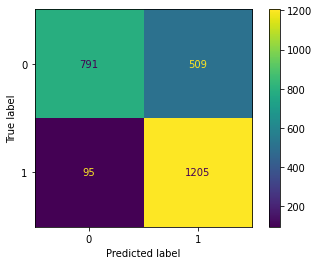

In [41]:
print(classification_metrics(labels, result)['accuracy'])

plot_conf_matrix(labels, result)

  0%|          | 0/1000 [00:00<?, ?it/s]

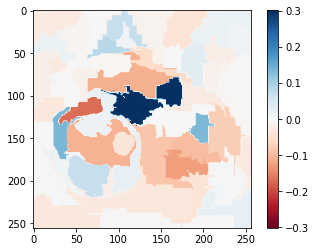

In [47]:
explainer = lime_image.LimeImageExplainer()

for images, labels in test_ds.take(1):
    im = images[0].numpy().astype('double')
    explanation = explainer.explain_instance(im, conv.predict, hide_color=0)

    ind = explanation.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()

## Resultaten
We hebben een accuracy van 0.78% kunnen halen.

## Conclusie

Convolutional nets zijn zeer geschikt om geparasiteerd cellen te klassificeren. Ons model werkt als zeker aardig goed,
maar hij is alsnog vrij primitief. Dit is een goed teken, want dat betekent dat met veel tweaken, en wat complexere
model structuur, een zeer goede accuracy realistisch is. Als we naar de confusion matrix kijken, dan zien we dat de 
grootste fouten false positives zijn, wat betekent dat we in een bepaalde richting kunnen kijken voor verbetering, e.g. 
andere image augmentation.

Ook als we naar de explainer heatmap kijken zien we wat interessante dingen. Bijvoorbeeld dat het model inderdaad een
correcte gewicht hecht aan het stuk hecht waar een parasiet zit, maar ok dat het een enorm negatief gewicht hecht aan
een ongerelateerd stuk. Dit betekent dat er misschien wat veranderd moet worden in de CNN opbouw.